<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Mattia Solla Sáez

* __Rol__: 201910501-9

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve, cross_validate


%matplotlib inline

In [ ]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [ ]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [ ]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

Empecemos analizando el tipo de de los datos, y notando que todos son enteros.

In [ ]:
digits.dtypes

c00       int64
c01       int64
c02       int64
c03       int64
c04       int64
          ...  
c60       int64
c61       int64
c62       int64
c63       int64
target    int64
Length: 65, dtype: object

Ahora, un poco de estadística descriptiva.

In [ ]:
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


Podemos notar que las casillas que se encuentran cerca de las esquinas tienen promedios más bajos (son "más blancas"), mientras que las casillas centrales tienen promedios más altos. \
Para verificar esto, grafiquemos la distribución de algunas casillas representativas.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWar

Text(0.5, 1.0, 'Casilla central')

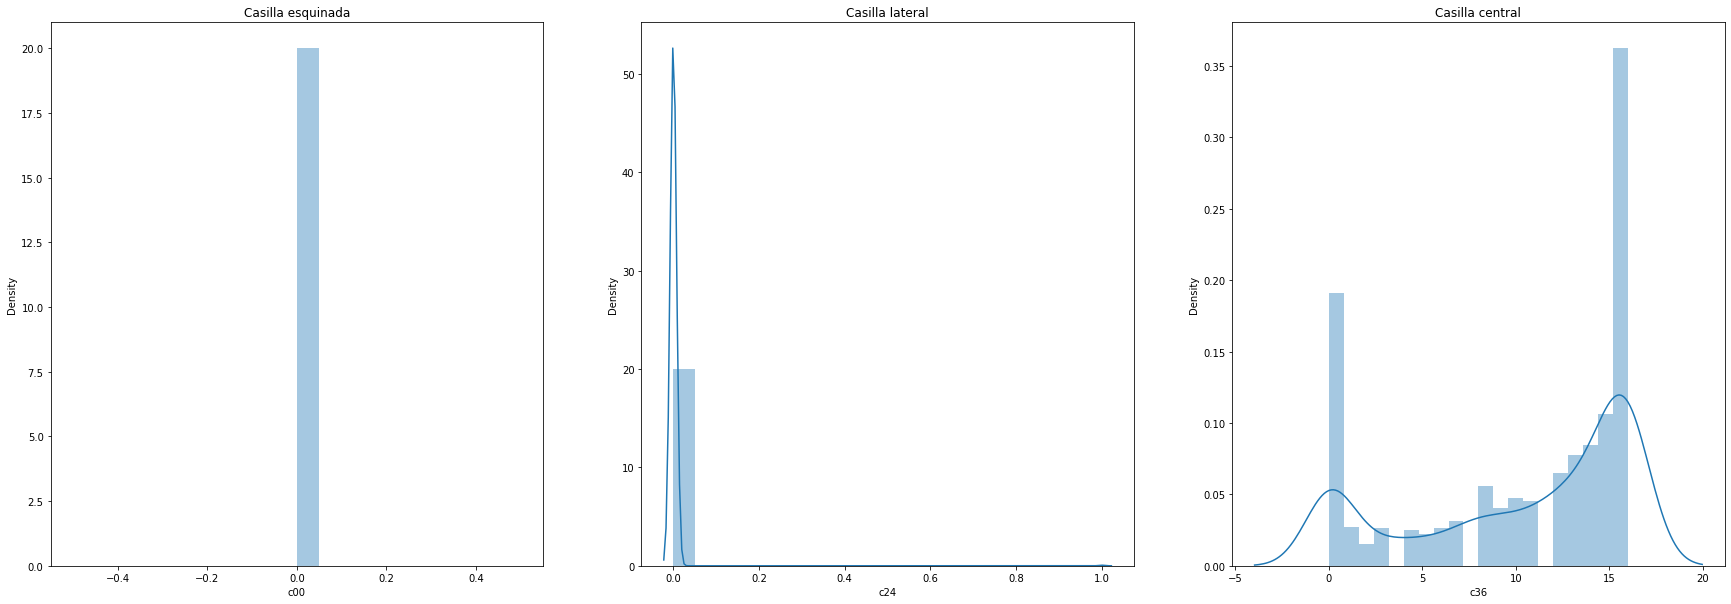

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
dist_1 = digits['c00'].astype(float)
sns.distplot(dist_1, bins=20, ax=ax[0])
ax[0].set_title('Casilla esquinada')
dist_2 = digits['c24'].astype(float)
sns.distplot(dist_2, bins=20, ax=ax[1])
ax[1].set_title('Casilla lateral')
dist_3 = digits['c36'].astype(float)
sns.distplot(dist_3, bins=20, ax=ax[2])
ax[2].set_title('Casilla central')

In [ ]:
def resumen_por_columna(df,cols):
    pd_series = df[cols]
    
    # elementos distintos 
    l_unique = pd_series.unique()
    
    # elementos vacios
    
    l_vacios = pd_series[pd_series.isna()]
    
    df_info = pd.DataFrame({
        'columna': [cols],
        'unicos': [len(l_unique)],
        'vacios': [len(l_vacios)]
    })
    
    return df_info

In [ ]:
frames = []

for col in digits.columns:
    aux_df = resumen_por_columna(digits,col)
    frames.append(aux_df)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(digits)
df_info


,columna,unicos,vacios,% vacios
0,c00,1,0,0.0
1,c01,9,0,0.0
2,c02,17,0,0.0
3,c03,17,0,0.0
4,c04,17,0,0.0
...,...,...,...,...
60,c60,17,0,0.0
61,c61,17,0,0.0
62,c62,17,0,0.0
63,c63,17,0,0.0


Lo más importante aquí es que no hay datos vacíos

In [ ]:
grupo = digits.groupby("target")
grupo = grupo[["c00"]].count().reset_index()
grupo = grupo.rename(columns={"c00":'cantidad'})
grupo

,target,cantidad
0,0,178
1,1,182
2,2,177
3,3,183
4,4,181
5,5,182
6,6,181
7,7,179
8,8,174
9,9,180


Podemos ver que las observaciones están distribuidas equitativamente entre todos los dígitos

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [ ]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

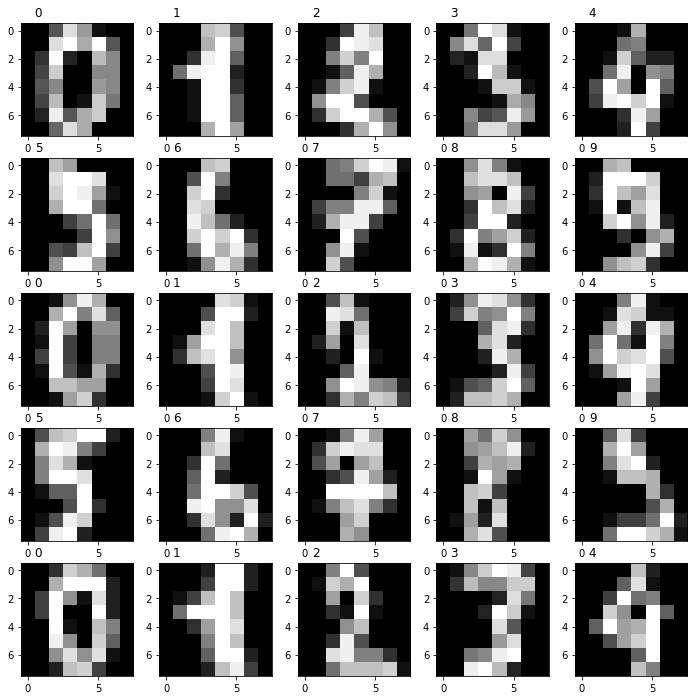

In [ ]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(nx):
  for j in range(ny):
    axs[i][j].imshow(digits_dict["images"][5*i+j],cmap="gray")
    axs[i][j].text(0.5,-1,str(digits_dict["target"][5*i+j]),fontsize=12)

plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [ ]:
scaler = StandardScaler()
X = digits.drop(columns="target").values
X = scaler.fit_transform(X)
y = digits["target"].values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 2022)
print(X_train.shape,X_test.shape)

(1437, 64) (360, 64)


In [ ]:
model = LogisticRegression(solver="saga", multi_class="ovr")

rango_penalty = ['l1','l2',"none"]
rango_C =np.array( [0.01,0.1,0.5,1,2,5,10,50,100])
param_grid = dict(penalty=rango_penalty, C=rango_C)
param_grid

{'penalty': ['l1', 'l2', 'none'],
 'C': array([1.e-02, 1.e-01, 5.e-01, 1.e+00, 2.e+00, 5.e+00, 1.e+01, 5.e+01,
        1.e+02])}

In [ ]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

KeyboardInterrupt: ignored

In [ ]:
model = KNeighborsClassifier()

rango_weights = ['distance','uniform']
rango_n =np.array( [2,5,10,15,25,50])
param_grid = dict(weights=rango_weights, n_neighbors=rango_n)
param_grid

{'weights': ['distance', 'uniform'],
 'n_neighbors': array([ 2,  5, 10, 15, 25, 50])}

In [ ]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9721617305458767
{'n_neighbors': 10, 'weights': 'distance'}


In [ ]:
model = DecisionTreeClassifier()

rango_criterion = ['gini','entropy']
rango_max_depth =np.array( [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150])
param_grid = dict(criterion=rango_criterion, max_depth=rango_max_depth)
param_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  15,  20,  30,  40,
         50,  70,  90, 120, 150])}

In [ ]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.873352206736353
{'criterion': 'entropy', 'max_depth': 40}


In [ ]:
def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['accuracy'] = [round(accuracy_score(y_true,y_pred),4)]
    df_result['recall'] = [round(recall_score(y_true,y_pred, average="macro"),4)]
    df_result['precision'] = [round(precision_score(y_true,y_pred, average="macro"),4)]
    df_result['fscore'] = [round(f1_score(y_true,y_pred, average="macro"),4)]


    return df_result

class SklearnClassificationModels:
    def __init__(self,model,name_model):

        self.model = model
        self.name_model = name_model
        
    @staticmethod
    def test_train_model(X,y,n_size):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=n_size , random_state=42)
        return X_train, X_test, y_train, y_test
    
    def fit_model(self,X,y,test_size):
        X_train, X_test, y_train, y_test = self.test_train_model(X,y,test_size )
        return self.model.fit(X_train, y_train) 
    
    def df_testig(self,X,y,test_size):
        X_train, X_test, y_train, y_test = self.test_train_model(X,y,test_size )
        model_fit = self.model.fit(X_train, y_train)
        preds = model_fit.predict(X_test)
        df_temp = pd.DataFrame(
            {
                'y':y_test,
                'yhat': model_fit.predict(X_test)
            }
        )
        
        return df_temp
    
    def metrics(self,X,y,test_size):
        df_temp = self.df_testig(X,y,test_size)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

El mejor modelo resultó ser el de vecinos más cercanos con 10 vecinos y pesos según la distancia. \
Ahora aplicaremos este modelo al conjunto de testeo.

In [ ]:
start_time = time()
model = KNeighborsClassifier(n_neighbors=10, weights='distance')
fit_model =  model.fit(X_train,Y_train)
end_time = time()

df_temp = pd.DataFrame(
            {
                'y':Y_test,
                'yhat': fit_model.predict(X_test)
            }
        )
resultados = summary_metrics(df_temp)
print(end_time-start_time)
print(resultados)
confusion_matrix(df_temp['y'],df_temp['yhat'])

0.0025815963745117188
   accuracy  recall  precision  fscore
0    0.9722  0.9725     0.9705  0.9707


array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  0,  0,  0,  0,  1,  2,  0],
       [ 0,  0,  0, 37,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 38,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 31]])

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

Generaremos el intervalo de confianza para el accuracy del modelo.

In [ ]:
accuracies = cross_validate(model, X, y=y, cv=10, scoring='accuracy')
accuracies

{'fit_time': array([0.00253129, 0.00198269, 0.00198674, 0.00224829, 0.00191402,
        0.00196195, 0.00190759, 0.00190473, 0.00187397, 0.00191545]),
 'score_time': array([0.02210355, 0.0122633 , 0.01208401, 0.01280975, 0.01201248,
        0.01155043, 0.01168275, 0.01165962, 0.01181316, 0.011127  ]),
 'test_score': array([0.92222222, 0.97222222, 0.97222222, 0.9       , 0.96111111,
        0.95555556, 0.97777778, 0.96648045, 0.94972067, 0.94413408])}

In [ ]:
prom = accuracies['test_score'].mean()
desv_est = np.std(accuracies['test_score'])
print('Accuracy =', prom, '+-', desv_est) 

Accuracy = 0.9521446306641836 +- 0.023335130110422705


Ahora graficaremos la curva de validación.

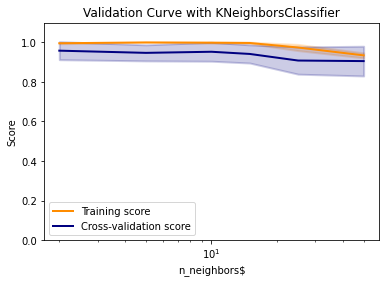

In [ ]:
subset_mask = np.isin(y, [1, 2])  # binary classification: 1 vs 2
X, y = X[subset_mask], y[subset_mask]

param_range = np.asarray([2,5,10,15,25,50])
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X,
    y,
    param_name="n_neighbors",
    param_range=np.asarray([2,5,10,15,25,50]),
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNeighborsClassifier")
plt.xlabel("n_neighbors$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

A continuación, un intento fallido de graficar la curva AUC-ROC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

y_b = label_binarize(y, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_b.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_b, test_size=0.8, random_state=2022)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    KNeighborsClassifier(n_neighbors=10,weights="distance")
)
y_score = classifier.fit(X_train, y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 8 is present in all training examples.
  warning

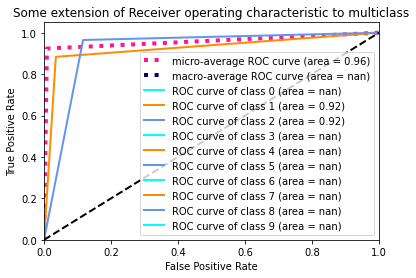

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


Empecemos extrayendo atributos a través de PCA. Consideraremos el menor número de atributos para explicar el 90% de la varianza de los datos.

In [ ]:
embedding = PCA(n_components=0.90)
X_extract = embedding.fit_transform(X)
X_extract.shape

(1797, 31)

Ahora seleccionemos las mejores 31 variables (para que coincidan las dimensiones entre os métodos) de acuerdo al estadístico f.

In [ ]:
X_select = SelectKBest(k=31).fit_transform(X,y)
X_select.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(1797, 31)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_extract, y, test_size=0.2, random_state = 2022)

start_time = time()
model = KNeighborsClassifier(n_neighbors=10, weights='distance')
fit_model =  model.fit(X_train,Y_train)
end_time = time()

df_temp = pd.DataFrame(
            {
                'y':Y_test,
                'yhat': fit_model.predict(X_test)
            }
        )
resultados = summary_metrics(df_temp)
print(end_time-start_time)
print(resultados)
confusion_matrix(df_temp['y'],df_temp['yhat'])

0.000911712646484375
   accuracy  recall  precision  fscore
0    0.9694  0.9699     0.9676  0.9678


array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  0,  0,  0,  0,  1,  2,  0],
       [ 0,  0,  0, 36,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0, 38,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 31]])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_select, y, test_size=0.2, random_state = 2022)

start_time = time()
model = KNeighborsClassifier(n_neighbors=10, weights='distance')
fit_model =  model.fit(X_train,Y_train)
end_time = time()

df_temp = pd.DataFrame(
            {
                'y':Y_test,
                'yhat': fit_model.predict(X_test)
            }
        )
resultados = summary_metrics(df_temp)
print(end_time-start_time)
print(resultados)
confusion_matrix(df_temp['y'],df_temp['yhat'])

0.0010724067687988281
   accuracy  recall  precision  fscore
0    0.9639  0.9639     0.9618  0.9622


array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 41,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 30,  0,  0,  0,  0,  1,  2,  0],
       [ 0,  0,  1, 35,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  0, 38,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0, 42,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  1, 29,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0, 31]])

Con ambos métodos logramos reducir el tiempo de ejecución a menos de la mitad, sin perder casi nada de precisión. Si bien el tiempo en este caso era pequeño de todas formas, se evidencia la importancia de la reducción de dimensionalidad.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [ ]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_pred = np.asarray(y_pred)
    y_aux_pred = y_pred[mask]
    print(y_aux_pred.shape)
    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if y_aux_pred.shape[0]>index:
              data  = X_aux[index, :].reshape(8,8)
              label_pred = str(int(y_aux_pred[index]))
              label_true = str(int(y_aux_true[index]))
              ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
              ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
              ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
              ax[i][j].get_xaxis().set_visible(False)
              ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

(353,)


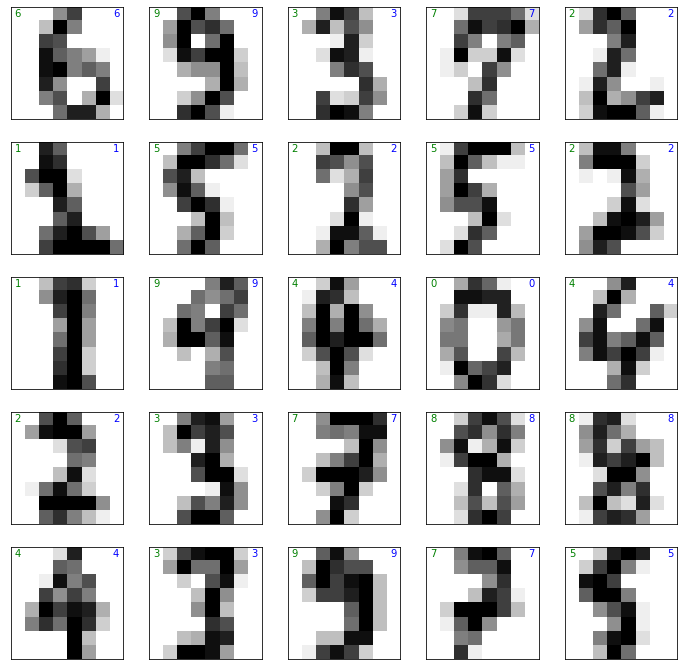

In [ ]:
mostar_resultados(digits,model)

(7,)


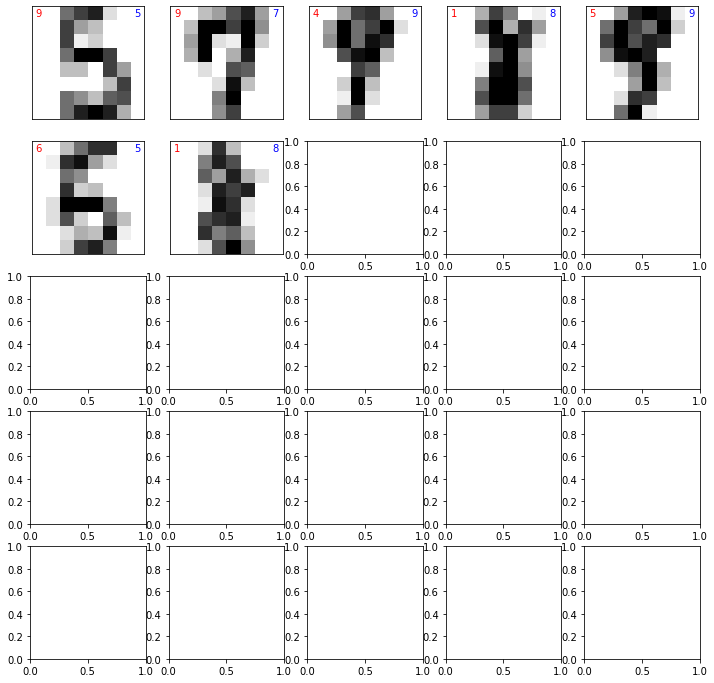

In [ ]:
mostar_resultados(digits,model,label="incorrectos")

### Ejercicio 7
**Conclusiones**: Los resultados obtenidos con el modelo son muy buenos (todas las métricas estásn sobre el 95%), por lo que se cumplió el objetivo de poder reconocer adecuadamente los dígitos. \
Por otro lado los resultados son muy estables ante variaciones en la elección de los conjuntos de entrenamiento y testeo y también de los distintos hiperparámetros. \
Por último, es importante destacar que se obtuvieron resultados muy similares al trabajar con menor cantidad de dimensiones, y reduciendo a la mitad el tiempo de entrenamiento, lo que se debe tener en cuenta para posibles trabajos futuros (con datasets más grandes).

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

Queremos predecir los valores medianos de las propiedades a partir de un modelo de regresión, considerando los datos descritos anteriormente. \
Estas predicciones pueden ser muy importantes para posibles inversionistas a la hora de construir nuevas viviendas, ya que dependerán de datos que se pueden conocer de manera exacta antes de empezar el proyecto de construcción

#funciones

In [35]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve, cross_validate, ShuffleSplit

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

#eda

In [4]:
# read data
housing = pd.read_csv('/content/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Empecemos con etstadística descriptiva para las variables numéricas.

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Notemos que los rangos de las variables son muy grandes (diversos órdenes de magnitud) y que se tienden a acumular en valores pequeños. \
Para comprobar esta hipótesis, grafiquemos la distribución de algunas variables relevantes.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ingreso mediano')

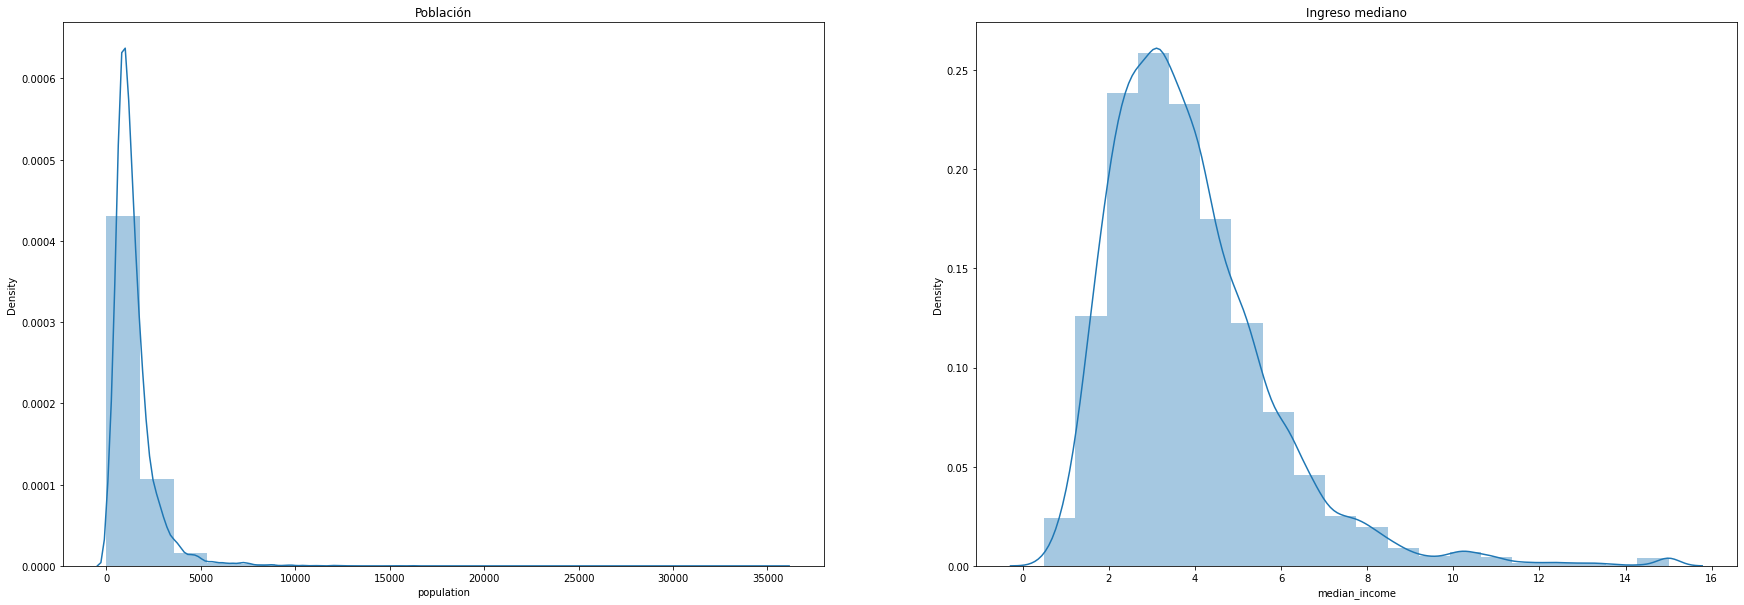

In [8]:
fig,ax = plt.subplots(1,2,figsize=(30,10))
dist_1 = housing['population'].astype(float)
sns.distplot(dist_1, bins=20, ax=ax[0])
ax[0].set_title('Población')
dist_2 = housing['median_income'].astype(float)
sns.distplot(dist_2, bins=20, ax=ax[1])
ax[1].set_title('Ingreso mediano')

Se cumple lo esperado.

In [9]:
def resumen_por_columna(df,cols):
    pd_series = df[cols]
    
    # elementos distintos 
    l_unique = pd_series.unique()
    
    # elementos vacios
    
    l_vacios = pd_series[pd_series.isna()]
    
    df_info = pd.DataFrame({
        'columna': [cols],
        'unicos': [len(l_unique)],
        'vacios': [len(l_vacios)]
    })
    
    return df_info
frames = []

for col in housing.columns:
    aux_df = resumen_por_columna(housing,col)
    frames.append(aux_df)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(housing)
df_info

,columna,unicos,vacios,% vacios
0,longitude,844,0,0.000000
1,latitude,862,0,0.000000
2,housing_median_age,52,0,0.000000
3,total_rooms,5926,0,0.000000
4,total_bedrooms,1924,207,0.010029
5,population,3888,0,0.000000
6,households,1815,0,0.000000
7,median_income,12928,0,0.000000
8,median_house_value,3842,0,0.000000
9,ocean_proximity,5,0,0.000000


Hay datos vacíos en la columna total_bedrooms. Los reemplazaremos por el promedio de la columna para incorporarlos al modelo.

In [10]:
prom = np.mean(housing["total_bedrooms"])
housing.loc[housing["total_bedrooms"].isna(),"total_bedrooms"] = prom 

In [11]:
frames = []

for col in housing.columns:
    aux_df = resumen_por_columna(housing,col)
    frames.append(aux_df)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(housing)
df_info

,columna,unicos,vacios,% vacios
0,longitude,844,0,0.0
1,latitude,862,0,0.0
2,housing_median_age,52,0,0.0
3,total_rooms,5926,0,0.0
4,total_bedrooms,1924,0,0.0
5,population,3888,0,0.0
6,households,1815,0,0.0
7,median_income,12928,0,0.0
8,median_house_value,3842,0,0.0
9,ocean_proximity,5,0,0.0


La columna ocean_proximity contiene datos categóricos. Para poder incorporarlos al modelo, los reemplazaremos por datos enteros ordenados por distancia al oceáno.

In [12]:
np.unique(housing["ocean_proximity"])

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [13]:
diccio = {
    'ISLAND' : 0,
    'NEAR OCEAN': 1,
    'NEAR BAY': 2,
    '<1H OCEAN': 3,
    'INLAND': 4
}
for key in diccio:
  housing.loc[housing['ocean_proximity']==key,'proximity_code'] = float(diccio[key])
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,proximity_code
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,2.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,2.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,2.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2.0


In [14]:
np.unique(housing['proximity_code'])

array([0., 1., 2., 3., 4.])

Por último, estudiemos la matriz de correlación de nuestros datos.

In [15]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,proximity_code
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069260,0.099773,0.055310,-0.015176,-0.045967,0.094976
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066658,-0.108785,-0.071035,-0.079809,-0.144160,0.164030
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.318998,-0.296244,-0.302916,-0.119034,0.105623,-0.211697
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927253,0.857126,0.918484,0.198050,0.134153,0.026423
total_bedrooms,0.069260,-0.066658,-0.318998,0.927253,1.000000,0.873910,0.974725,-0.007682,0.049454,0.003059
population,0.099773,-0.108785,-0.296244,0.857126,0.873910,1.000000,0.907222,0.004834,-0.024650,0.026992
households,0.055310,-0.071035,-0.302916,0.918484,0.974725,0.907222,1.000000,0.013033,0.065843,-0.016369
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007682,0.004834,0.013033,1.000000,0.688075,-0.150436
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049454,-0.024650,0.065843,0.688075,1.000000,-0.383244
proximity_code,0.094976,0.164030,-0.211697,0.026423,0.003059,0.026992,-0.016369,-0.150436,-0.383244,1.000000


Podemos notar que las únicas variables que se correlacionan significativamente con el valor mediano de la vivienda (la variable a predecir) son el ingreso mediano y la cercanía al océano.

#modelos

In [16]:
data = housing.drop("ocean_proximity",axis=1)
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,proximity_code
0,-1.327835,1.052548,0.982143,-0.804819,-0.975228,-0.974429,-0.977033,2.344766,2.129631,-0.976419
1,-1.322844,1.043185,-0.607019,2.045890,1.355088,0.861439,1.669961,2.332238,1.314156,-0.976419
2,-1.332827,1.038503,1.856182,-0.535746,-0.829732,-0.820777,-0.843637,1.782699,1.258693,-0.976419
3,-1.337818,1.038503,1.856182,-0.624215,-0.722399,-0.766028,-0.733781,0.932968,1.165100,-0.976419
4,-1.337818,1.038503,1.856182,-0.462404,-0.615066,-0.759847,-0.629157,-0.012881,1.172900,-0.976419


In [17]:
X = data.drop(columns='median_house_value').values
y = data['median_house_value'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 2022)
print(X_train.shape,X_test.shape)

(16512, 9) (4128, 9)


Probaremos cuatro modelos. Además, como solo hay 10 variables regresoras, no se utilizarán métodos de reducción de dimensionalidad (pues no tendría mucho sentido). 

In [18]:
model = LinearRegression()

#rango_alpha =np.array( [0.01,0.1,0.5,1,2,5,10,50,100])
param_grid = dict()
param_grid

{}

In [19]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='r2',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.6372717870980209
{}


In [20]:
model = Ridge()

rango_alpha =np.array( [0.01,0.1,0.5,1,2,5,10,50,100])
param_grid = dict(alpha=rango_alpha)
param_grid

{'alpha': array([1.e-02, 1.e-01, 5.e-01, 1.e+00, 2.e+00, 5.e+00, 1.e+01, 5.e+01,
        1.e+02])}

In [21]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='r2',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.637288626645622
{'alpha': 10.0}


In [22]:
model = DecisionTreeRegressor()

rango_criterion = np.array(['squared_error', 'absolute_error'])
rango_depth = np.array([10,11,12,15,20,30,40,50,70])
param_grid = dict(criterion=rango_criterion, max_depth=rango_depth)
param_grid

{'criterion': array(['squared_error', 'absolute_error'], dtype='<U14'),
 'max_depth': array([10, 11, 12, 15, 20, 30, 40, 50, 70])}

In [23]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='r2',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7030978107895327
{'criterion': 'squared_error', 'max_depth': 10}


In [24]:
model = LinearSVR()

rango_C =np.array( [0.01,0.1,0.5,1,2,5,10,50,100])
param_grid = dict(C=rango_C)
param_grid

{'C': array([1.e-02, 1.e-01, 5.e-01, 1.e+00, 2.e+00, 5.e+00, 1.e+01, 5.e+01,
        1.e+02])}

In [25]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='r2',
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)
print(gs.best_score_)
print(gs.best_params_)

0.6257309400412419
{'C': 1.0}


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [28]:
start_time = time()
model = DecisionTreeRegressor(max_depth=10, criterion='squared_error')
fit_model =  model.fit(X_train,Y_train)
end_time = time()

df_temp = pd.DataFrame(
            {
                'y':Y_test,
                'yhat': fit_model.predict(X_test)
            }
        )
resultados = summary_metrics(df_temp)
print(end_time-start_time)
print(resultados)


0.10172080993652344
      mae     mse    rmse    mape  maape    wmape   mmape   smape
0  0.3472  0.2738  0.5232  2.2562  0.498 -12.2691  0.2047  0.7165


Notemos que los errores son pequeños. Para analizar el r2, utilizaremos validación cruzada.

In [37]:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
scores = cross_validate(model, X, y=y, cv=cv, scoring='r2')
scores

{'fit_time': array([0.11400366, 0.09902835, 0.11536694, 0.10409021, 0.12112737,
        0.09529471, 0.08668995, 0.08117223, 0.08344865, 0.08017588]),
 'score_time': array([0.00182748, 0.00162864, 0.00165892, 0.00161672, 0.00180411,
        0.0011909 , 0.00127721, 0.00135803, 0.00132084, 0.00119853]),
 'test_score': array([0.70594589, 0.71024866, 0.70008605, 0.71324206, 0.6892989 ,
        0.72048533, 0.70155083, 0.72522909, 0.7103871 , 0.71424973])}

In [39]:
prom = scores['test_score'].mean()
desv_est = np.std(scores['test_score'])
print('R2 =', prom, '+-', desv_est) 

R2 = 0.7090723648916801 +- 0.009882768984028283


#Conclusiones

El modelo encontrado predice con buena precisión los valores medianos de las propiedades. Además los resultados obtenidos son muy consistentes respecto a las métricas consideradas y también a los conjuntos de entrenamiento y testeo considerados. \
